# SVM regression
## imports of libraries and data, adjusting features

In [33]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import psutil
import os
import sys
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
import datetime as datetime
import seaborn as sns

process = psutil.Process(os.getpid())

### Atributes - short explanation
The default name indicating the case ID is case:concept:name
concept:name is the event
time:timestamp is the corresponding timestamp

Load the datasets, sort them on case and consequently timestamp, then reset the index:

In [2]:
df_train = pd.read_csv('bpi2017_train.csv', parse_dates = ['time:timestamp'])
df_test = pd.read_csv('bpi2017_test.csv', parse_dates = ['time:timestamp'])
df_val = pd.read_csv('bpi2017_val.csv', parse_dates = ['time:timestamp'])

In [3]:
df_train = df_train.sort_values(by = ['case:concept:name', 'time:timestamp']).reset_index()
df_val = df_val.sort_values(by = ['case:concept:name', 'time:timestamp']).reset_index()
df_test = df_test.sort_values(by = ['case:concept:name', 'time:timestamp']).reset_index()

# Remove obsolete columns
df_train = df_train.drop(['index', 'Unnamed: 0'], axis = 1)
df_val = df_val.drop(['index', 'Unnamed: 0'], axis = 1)
df_test = df_test.drop(['index', 'Unnamed: 0'], axis = 1)

## calculate time difference
procedure same as in Baseline algorithm B

In [4]:
# Cumulative sum function to be used later
def CumSum(lists):
    # Returns the cumulative sum of a list
    length = len(lists)
    cu_list = [sum(lists[0: x: 1]) for x in range(0, length + 1)]
    return cu_list[1: ]   
def time_difference(df):
    # Calculate time difference between each row
    df['time_diff'] = df['time:timestamp'].diff().dt.total_seconds()
    # Set the time difference of the 1st row to 0 as it's currently NaN
    df.at[0, 'time_diff'] = 0
    # Count number of steps per process
    length_per_case_List = df.groupby(['case:concept:name'])['time_diff'].count().tolist()

    # Using the cumulative sum we get all the positions that are a first step in a process
    # And then the time difference can be set to 0
    position_lst = CumSum(length_per_case_List)
    for i in tqdm(position_lst):
        df.at[i, 'time_diff'] = 0
    # For Loop mysteriously creates an empty row at the end of the df, gotta delete it
    df = df.iloc[: -1]

    # Unzip the position list to get the number of each steps of each process, make that into a list
    step_in_process = []
    for x in tqdm(length_per_case_List):
        for y in range(x):
            step_in_process.append(y + 1)
    # Assign position number to each row/process
    df['position'] = step_in_process
    return df

In [5]:
# Apply the above changes to all dataframes
# The warnings are obsolete, it's because it uses .at which is considerably faster than .loc
df_train = time_difference(df_train)
df_val = time_difference(df_val)
df_test = time_difference(df_test)

100%|█████████████████████████████████| 16308/16308 [00:00<00:00, 383635.69it/s]
/var/folders/lh/s2l49w850tq2lvbfyqst82j00000gn/T/ipykernel_44404/3219029282.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['position'] = step_in_process
100%|█████████████████████████████████████| 751/751 [00:00<00:00, 143517.51it/s]


In [9]:
# one hot encoding
df_train_f = pd.get_dummies(df_train, columns = ['concept:name'])
df_test_f = pd.get_dummies(df_test, columns = ['concept:name'])

In [12]:
# factorization of categorical atrtibutes (of interest) of the training data
# should be replaced with some "smarter" feature transformation
vals, code_Action = pd.factorize(df_train_f['Action'])
df_train_f['Action'] = vals

vals, code_Origin = pd.factorize(df_train_f['EventOrigin'])
df_train_f['EventOrigin'] = vals

vals, code_lifecycle_transition = pd.factorize(df_train_f['lifecycle:transition'])
df_train_f['lifecycle:transition'] = vals

vals, code_loan_goal = pd.factorize(df_train_f['case:LoanGoal'])
df_train_f['case:LoanGoal'] = vals

vals, code_appl_type = pd.factorize(df_train_f['case:ApplicationType'])
df_train_f['case:ApplicationType'] = vals

# vals, code_concept_name = pd.factorize(df_train_f['concept:name'])
# df_train_f['concept:name'] = vals

# and for test data
vals, code_Action = pd.factorize(df_test_f['Action'])
df_test_f['Action'] = vals

vals, code_Origin = pd.factorize(df_test_f['EventOrigin'])
df_test_f['EventOrigin'] = vals

vals, code_lifecycle_transition = pd.factorize(df_test_f['lifecycle:transition'])
df_test_f['lifecycle:transition'] = vals

vals, code_loan_goal = pd.factorize(df_test_f['case:LoanGoal'])
df_test_f['case:LoanGoal'] = vals

vals, code_appl_type = pd.factorize(df_test_f['case:ApplicationType'])
df_test_f['case:ApplicationType'] = vals

# vals, code_concept_name = pd.factorize(df_test_f['concept:name'])
# df_test_f['concept:name'] = vals

# to see the "code" - so which number corresponds to which class - print the code_... for the attribute of interest

In [14]:
df_test_f.columns

Index(['Action', 'org:resource', 'EventOrigin', 'EventID',
       'lifecycle:transition', 'time:timestamp', 'case:LoanGoal',
       'case:ApplicationType', 'case:concept:name', 'case:RequestedAmount',
       'FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost',
       'Selected', 'CreditScore', 'OfferedAmount', 'OfferID', 'time_diff',
       'position', 'concept:name_A_Accepted', 'concept:name_A_Cancelled',
       'concept:name_A_Complete', 'concept:name_A_Concept',
       'concept:name_A_Create Application', 'concept:name_A_Denied',
       'concept:name_A_Incomplete', 'concept:name_A_Pending',
       'concept:name_A_Submitted', 'concept:name_A_Validating',
       'concept:name_O_Accepted', 'concept:name_O_Cancelled',
       'concept:name_O_Create Offer', 'concept:name_O_Created',
       'concept:name_O_Refused', 'concept:name_O_Returned',
       'concept:name_O_Sent (mail and online)',
       'concept:name_O_Sent (online only)',
       'concept:name_W_Assess potential f

In [17]:
# select the features that will be used for prediction
features = ['Action', 'EventOrigin', 'lifecycle:transition', 'case:LoanGoal',
            'case:ApplicationType', 'case:RequestedAmount', 'position', 
            'concept:name_A_Accepted', 'concept:name_A_Cancelled',
            'concept:name_A_Complete', 'concept:name_A_Concept',
            'concept:name_A_Create Application', 'concept:name_A_Denied',
            'concept:name_A_Incomplete', 'concept:name_A_Pending',
            'concept:name_A_Submitted', 'concept:name_A_Validating',
            'concept:name_O_Accepted', 'concept:name_O_Cancelled',
            'concept:name_O_Create Offer', 'concept:name_O_Created',
            'concept:name_O_Refused', 'concept:name_O_Returned',
            'concept:name_O_Sent (mail and online)',
            'concept:name_O_Sent (online only)',
            'concept:name_W_Assess potential fraud',
            'concept:name_W_Call after offers',
            'concept:name_W_Call incomplete files',
            'concept:name_W_Complete application', 'concept:name_W_Handle leads',
            'concept:name_W_Validate application']

## Define predictors and outcome variables for train and test sets

In [18]:
# split the predictors and the outcome variable
X_train = df_train_f[features]
y_train = df_train_f['time_diff']
X_test = df_test_f[features]
y_test = df_test_f['time_diff']

## Initialize and fit the model (on a slice - to have a reasonable running time)

In [23]:
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.01, degree=3, verbose=True))
regr.fit(X_train[:100000], y_train[:100000])

[LibSVM].....................................................................
*.
*.....
*.*
optimization finished, #iter = 75592
obj = -4766777393.030747, rho = -146.113545
nSV = 99187, nBSV = 99019


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.01, verbose=True))])

In [27]:
regr.score(X_test[:5000], y_test[:5000])

-0.042084374702000105

## Make predictions for a slice of test

In [30]:
predictions = regr.predict(X_test[:200])

In [95]:
# compare the predictions with actual data and check accuracy (proportion of correct predictions)
compare_predictions = pd.DataFrame()
compare_predictions['true'] = y_test[:200]
compare_predictions['predicted'] = predictions
compare_predictions['position'] = X_test['position'][:200]
compare_predictions['diff'] = compare_predictions['true'] - compare_predictions['predicted']
mse = sum((compare_predictions['true']-compare_predictions['predicted'])**2)/200
mse
# compare_predictions[31:60]

119313458679.7947

### make visualizations of the predictions for the first two cases to see where things go wrong

In [82]:
plot_case1 = compare_predictions[:31].set_index('position')
plot_case1 = plot_case1[['true', 'predicted']].stack().to_frame()
plot_case1 = plot_case1.rename(columns={0: 'time'}).reset_index()
plot_case1 = plot_case1.rename(columns={'level_1': 'true/predicted'})
plot_case1

,position,true/predicted,time
0,1,true,0.000000
1,1,predicted,0.657409
2,2,true,1.086000
3,2,predicted,2.102987
4,3,true,0.279000
...,...,...,...
57,29,predicted,2.379414
58,30,true,0.007000
59,30,predicted,2.184848
60,31,true,0.017000


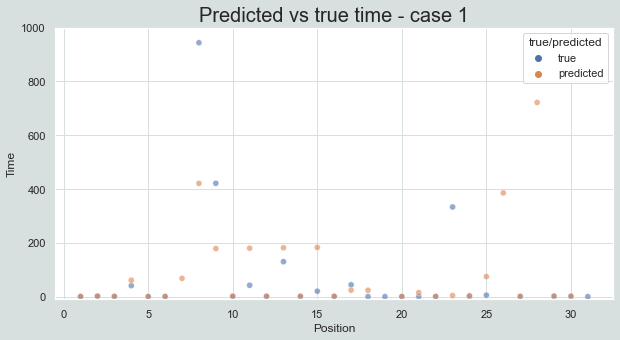

In [93]:
# figure size
sns.set(rc={'figure.figsize':(10,5)})
# color (palette) - general settings for the poster
colors = ["#494f56", "#d8dfdf"]

# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.set(rc={'axes.facecolor':'#ffffff', 'figure.facecolor':'#d8dfdf', 
            "grid.color":'#d8dfdf'})

ax = sns.scatterplot(data = plot_case1, x='position', y='time', hue='true/predicted', alpha=0.6);
ax.set_xlabel('Position')
ax.set_ylabel('Time')
ax.set_title('Predicted vs true time - case 1', size = 20);
# ax.set_ylim(-10, 1000);

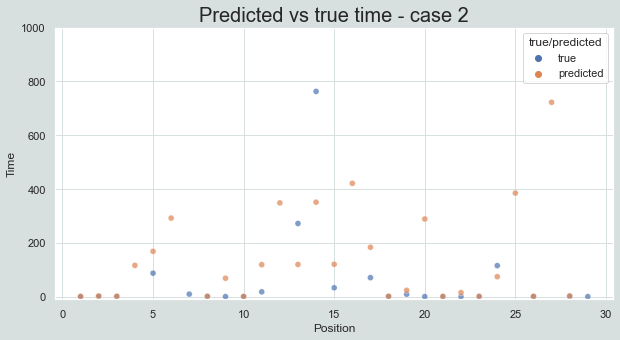

In [94]:
plot_case2 = compare_predictions[31:60].set_index('position')
plot_case2 = plot_case2[['true', 'predicted']].stack().to_frame()
plot_case2 = plot_case2.rename(columns={0: 'time'}).reset_index()
plot_case2 = plot_case2.rename(columns={'level_1': 'true/predicted'})

ax = sns.scatterplot(data = plot_case2, x='position', y='time', hue='true/predicted', alpha=0.7)
ax.set_xlabel('Position')
ax.set_ylabel('Time')
ax.set_title('Predicted vs true time - case 2', size = 20);
# ax.set_ylim(-10, 1000);

In [ ]:
print("Average memory usage: " +
      str((process.memory_info().rss) >> 20) + "MB")
print("CPU Time: " + str(process.cpu_times().user + process.cpu_times().system) + "s")